## K-Nearest-Neighbors

KNN falls in the supervised learning family of algorithms. Informally, this means that we are given a labelled dataset consiting of training observations (x,y) and would like to capture the relationship between x and y. More formally, our goal is to learn a function h:X→Y so that given an unseen observation x, h(x) can confidently predict the corresponding output y.

In this module we will explore the inner workings of KNN, choosing the optimal K values and using KNN from scikit-learn.

## Problem statement

### Dataset

The data set we’ll be using is the Iris Flower Dataset which was first introduced in 1936 by the famous statistician Ronald Fisher and consists of 50 observations from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals.

**Source:** https://archive.ics.uci.edu/ml/datasets/Iris

**Train the KNN algorithm to be able to distinguish the species from one another given the measurements of the 4 features.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
plt.rcParams['figure.figsize'] = [15,8]

## Question 1

#### Read the iris.csv file

In [3]:
df_iris = pd.read_csv('iris.csv')
df_iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df_iris.shape

(152, 6)

In [5]:
df_iris.dtypes

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

In [6]:
df_iris.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,152.000000,151.000000,150.000000,150.000000,151.000000
mean,76.500000,5.843709,3.054000,3.758667,1.202649
std,44.022721,0.825314,0.433594,1.764420,0.762185
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.750000,5.100000,2.800000,1.600000,0.300000
50%,76.500000,5.800000,3.000000,4.350000,1.300000
75%,114.250000,6.400000,3.300000,5.100000,1.800000
max,152.000000,7.900000,4.400000,6.900000,2.500000


## Data Pre-processing

## Question 2 - Estimating missing values

*Its not good to remove the records having missing values all the time. We may end up loosing some data points. So, we will have to see how to replace those missing values with some estimated values (median) *

In [7]:
df_iris.isnull().sum()

Id               0
SepalLengthCm    1
SepalWidthCm     2
PetalLengthCm    2
PetalWidthCm     1
Species          0
dtype: int64

In [8]:
df_iris['SepalLengthCm'] = df_iris['SepalLengthCm'].fillna(df_iris['SepalLengthCm'].median())

In [9]:
df_iris['SepalWidthCm'] = df_iris['SepalWidthCm'].fillna(df_iris['SepalWidthCm'].median())

In [10]:
df_iris['PetalLengthCm'] = df_iris['PetalLengthCm'].fillna(df_iris['PetalLengthCm'].median())

In [11]:
df_iris['PetalWidthCm'] = df_iris['PetalWidthCm'].fillna(df_iris['PetalWidthCm'].median())

In [12]:
df_iris.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

## Question 3 - Dealing with categorical data

Change all the classes to numericals (0to2).

In [13]:
df_iris['Species'].value_counts()

Iris-virginica     52
Iris-setosa        50
Iris-versicolor    50
Name: Species, dtype: int64

In [14]:
df_iris['Species'] = df_iris['Species'].map({'Iris-virginica':0,'Iris-versicolor':1,'Iris-setosa':2})

In [15]:
df_iris.dtypes

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species            int64
dtype: object

## Question 4

*Observe the association of each independent variable with target variable and drop variables from feature set having correlation in range -0.1 to 0.1 with target variable.*

In [16]:
df_iris.corr()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,1.000000,0.702734,-0.392693,0.872346,0.890676,-0.942753
SepalLengthCm,0.702734,1.000000,-0.109369,0.871120,0.815986,-0.775061
SepalWidthCm,-0.392693,-0.109369,1.000000,-0.420713,-0.356510,0.417318
PetalLengthCm,0.872346,0.871120,-0.420713,1.000000,0.962043,-0.944477
PetalWidthCm,0.890676,0.815986,-0.356510,0.962043,1.000000,-0.952513
Species,-0.942753,-0.775061,0.417318,-0.944477,-0.952513,1.000000


## Question 5

*Observe the independent variables variance and drop such variables having no variance or almost zero variance(variance < 0.1). They will be having almost no influence on the classification.*

In [17]:
df_iris.var()

Id               1938.000000
SepalLengthCm       0.676645
SepalWidthCm        0.185552
PetalLengthCm       3.076516
PetalWidthCm        0.577141
Species             0.675322
dtype: float64

## Question 6

*Plot the scatter matrix for all the variables.*

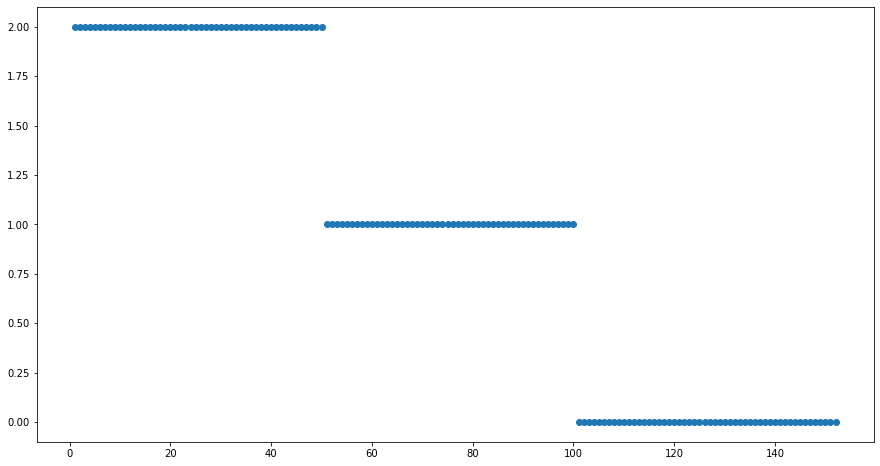

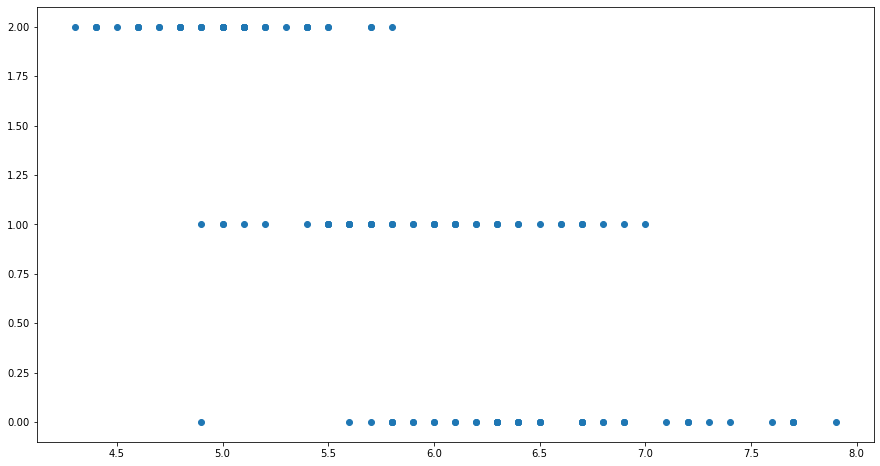

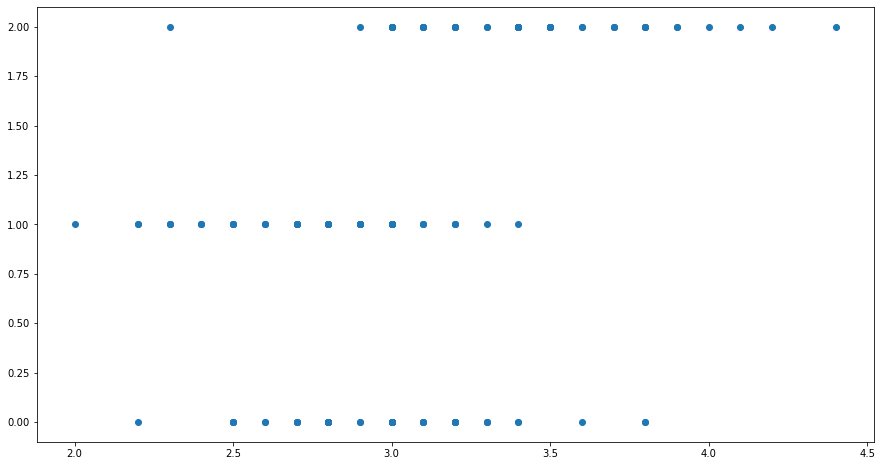

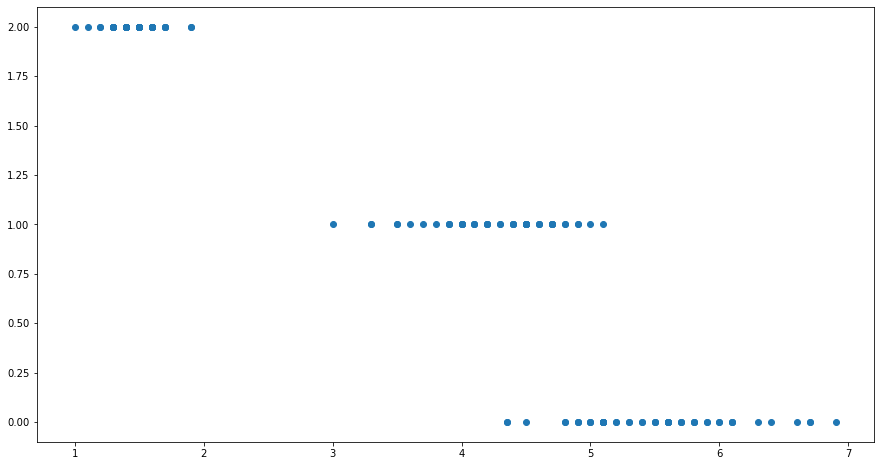

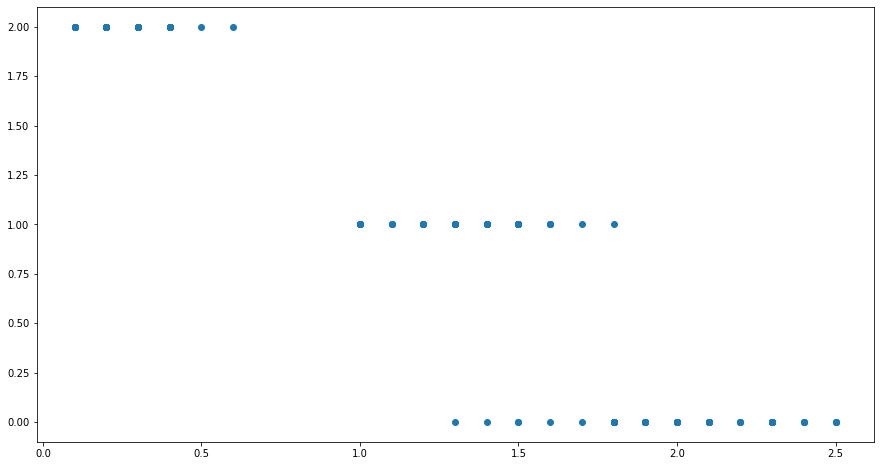

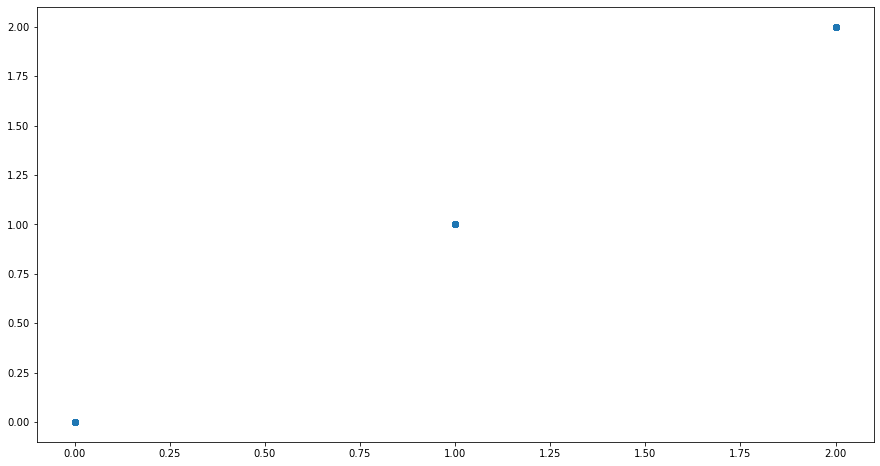

In [18]:
for col in df_iris:
    plt.scatter(x=df_iris[col],y=df_iris['Species'])
    plt.show()

## Split the dataset into training and test sets

## Question 7

*Split the dataset into training and test sets with 80-20 ratio.*

In [19]:
X = df_iris.iloc[:,:5]
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(X)
X = pd.DataFrame(num_scaled,columns=X.columns)
Y = df_iris['Species']
X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size=0.8,random_state=1)

## Question 8 - Model

*Build the model and train and test on training and test sets respectively using **scikit-learn**. Print the Accuracy of the model with different values of **k=3,5,9**.*

**Hint:** For accuracy you can check **accuracy_score()** in scikit-learn

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)

knn_model = knn.fit(X_train,y_train)

y_pred = knn_model.predict(X_test)

print('Accuracy Score',accuracy_score(y_test,y_pred))

Accuracy Score 1.0


In [21]:
knn = KNeighborsClassifier(n_neighbors=5)

knn_model = knn.fit(X_train,y_train)

y_pred = knn_model.predict(X_test)

print('Accuracy Score',accuracy_score(y_test,y_pred))

Accuracy Score 1.0


In [22]:
knn = KNeighborsClassifier(n_neighbors=9)

knn_model = knn.fit(X_train,y_train)

y_pred = knn_model.predict(X_test)

print('Accuracy Score',accuracy_score(y_test,y_pred))

Accuracy Score 1.0


## Question 9 - Cross Validation

Run the KNN with no of neighbours to be 1,3,5..19 and *Find the **optimal number of neighbours** from the above list using the Mis classification error

Hint:

Misclassification error (MSE) = 1 - Test accuracy score. Calculated MSE for each model with neighbours = 1,3,5...19 and find the model with lowest MSE

In [23]:
accuracy = []

for i in np.arange(1,21,2):
    
    knn = KNeighborsClassifier(i)
    
    score = cross_val_score(knn,X_train,y_train,cv=5,scoring='f1_weighted')
    
    scores = np.mean(score)
    
    accuracy.append(scores)

In [24]:
accuracy

[0.9752647984969967,
 0.9836993464052288,
 0.9916993464052288,
 0.9916993464052288,
 0.9916993464052288,
 0.9916993464052288,
 0.9916993464052288,
 0.9836993464052288,
 0.9836993464052288,
 0.9836993464052288]

In [25]:
MSE = (np.array([1])-accuracy)
MSE

array([0.0247352 , 0.01630065, 0.00830065, 0.00830065, 0.00830065,
       0.00830065, 0.00830065, 0.01630065, 0.01630065, 0.01630065])

Neighbors with 5,7,9,11 and 13 has lowest Misclassificationerror(MSE) compared to other neighbors

## Question 10

*Plot misclassification error vs k (with k value on X-axis) using matplotlib.*

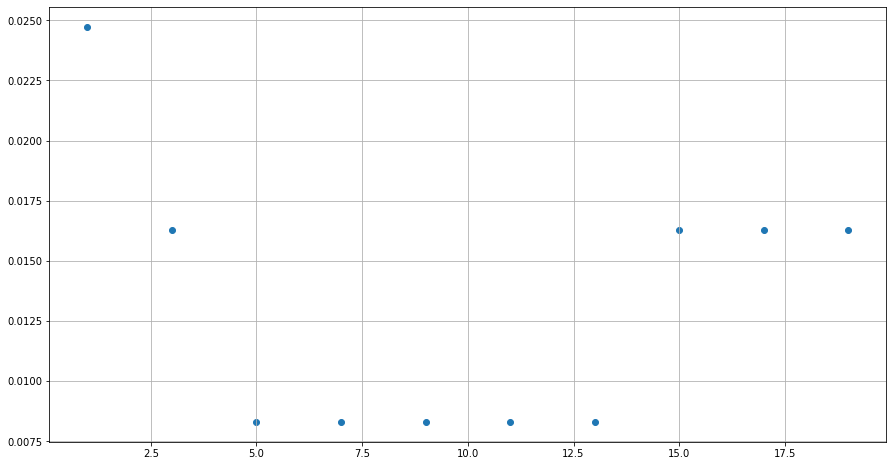

In [26]:
plt.scatter(np.arange(1,21,2),MSE)
plt.grid(True)
plt.show()

# Naive Bayes

In [43]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

### Question 1
#### Import Iris.csv

In [28]:
df = pd.read_csv('iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [29]:
df.shape

(152, 6)

In [30]:
df.isnull().sum()

Id               0
SepalLengthCm    1
SepalWidthCm     2
PetalLengthCm    2
PetalWidthCm     1
Species          0
dtype: int64

In [31]:
for col in ['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']:
    df[col] = df[col].fillna(df[col].median())

In [32]:
df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

### Question 2
#### Slice data set for Independent variables and dependent variables
#### Please note 'Species' is my dependent variables, name it y and independent set data as X

In [33]:
X = df.iloc[:,:5]
Y = df['Species']

## Question 3
#### Find the distribution of target variable (Class)
#### And, Plot the distribution of target variable using histogram

In [34]:
df['Species'].value_counts()

Iris-virginica     52
Iris-setosa        50
Iris-versicolor    50
Name: Species, dtype: int64

### Plot the distribution of target variable using histogram

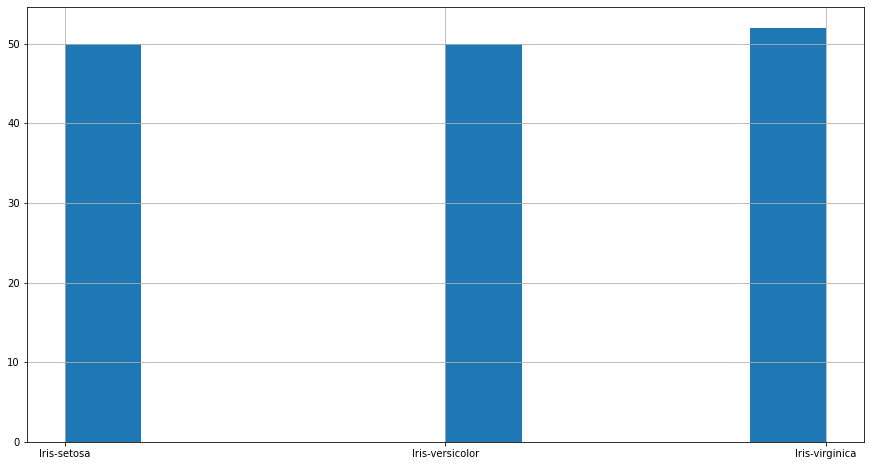

In [35]:
df['Species'].hist()
plt.show()

### Plot Scatter Matrix to understand the distribution of variables and give insights from it.

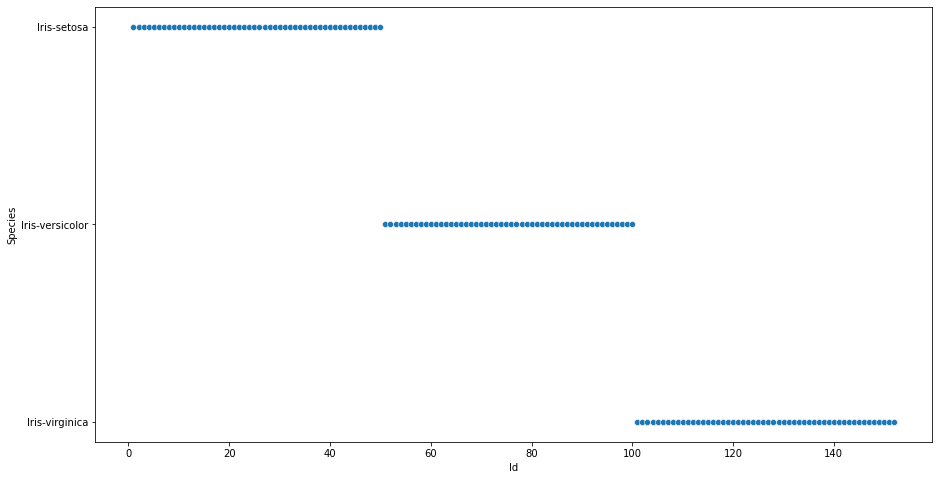

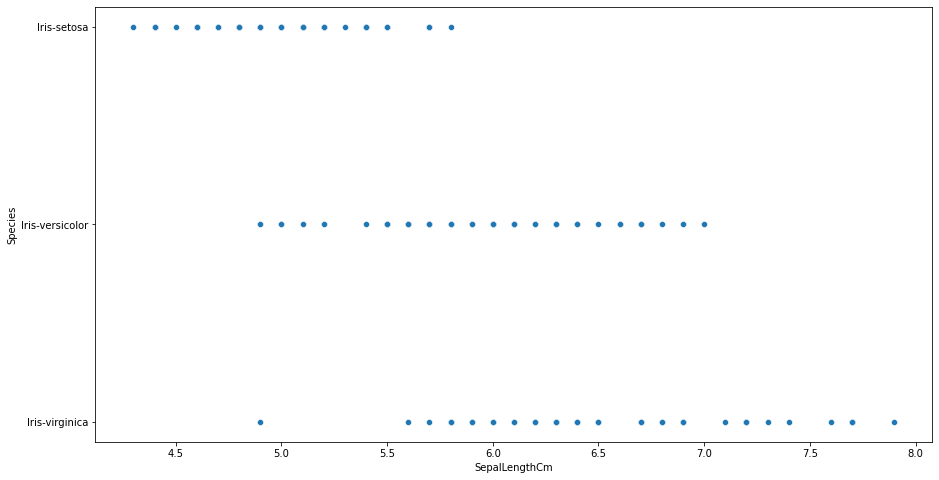

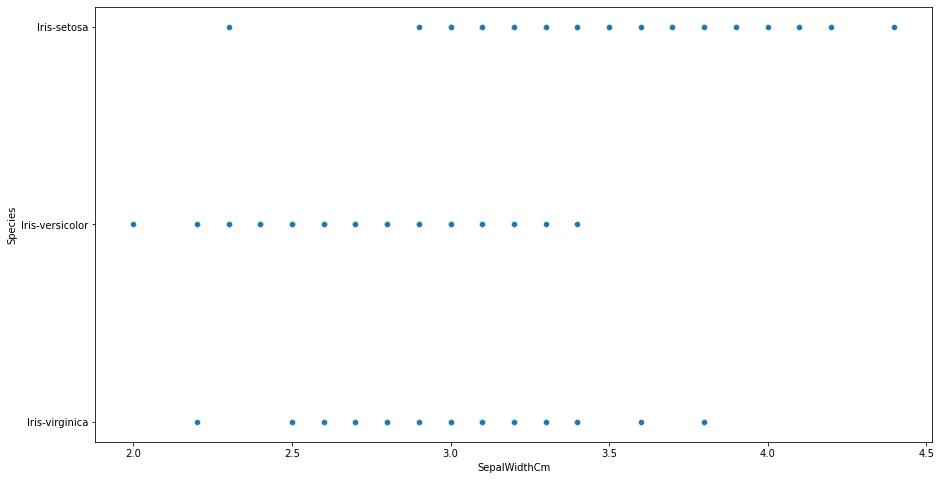

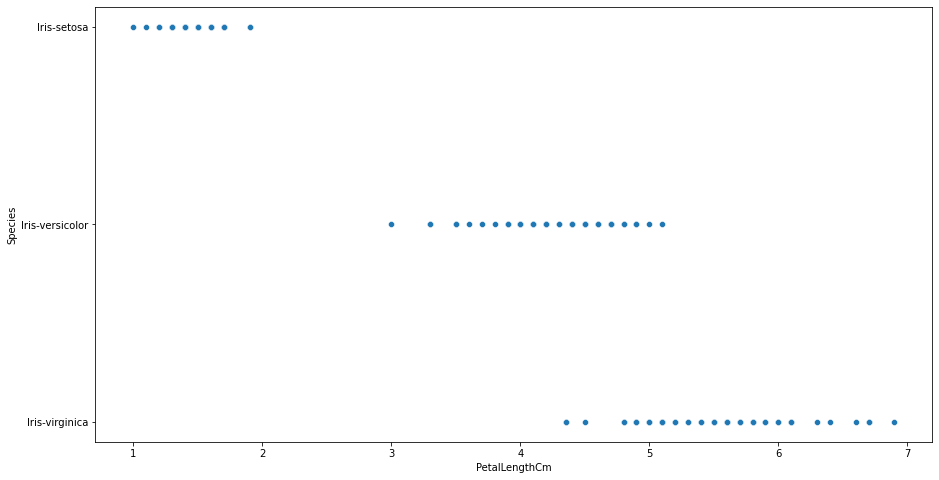

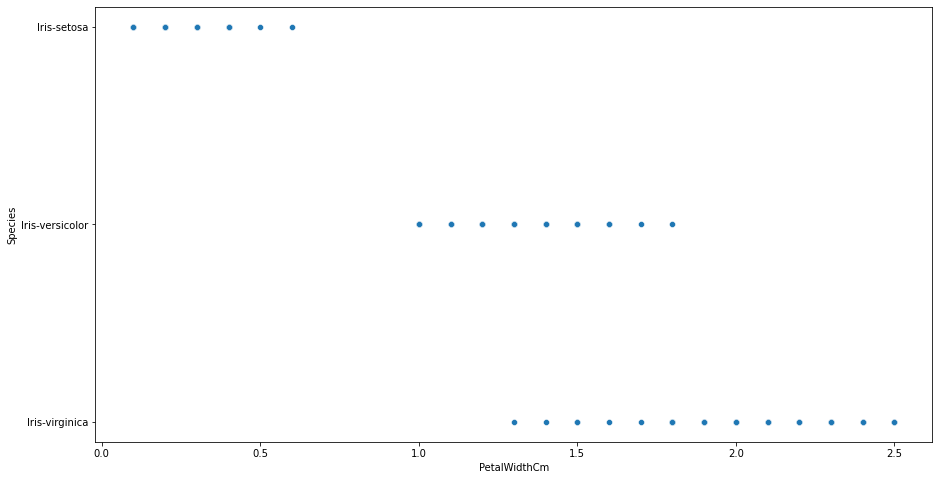

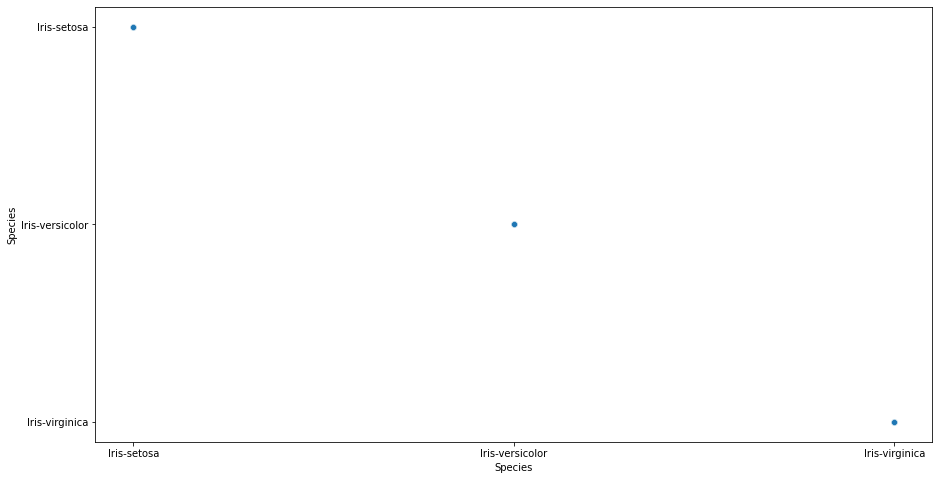

In [36]:
for col in df:
    sns.scatterplot(df[col],df['Species'])
    plt.show()

The variables are non-linearly distributed

### Question 3
#### Find Correlation among all variables and give your insights 

In [37]:
df.corr()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Id,1.000000,0.702734,-0.392693,0.872346,0.890676
SepalLengthCm,0.702734,1.000000,-0.109369,0.871120,0.815986
SepalWidthCm,-0.392693,-0.109369,1.000000,-0.420713,-0.356510
PetalLengthCm,0.872346,0.871120,-0.420713,1.000000,0.962043
PetalWidthCm,0.890676,0.815986,-0.356510,0.962043,1.000000


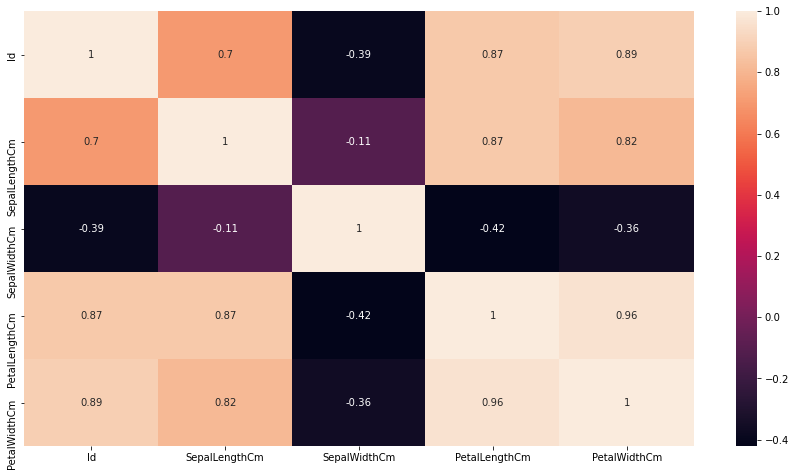

In [38]:
sns.heatmap(df.corr(),annot=True)
plt.show()

All the variables have high correlation 


### Question 4
#### Split data in Training and Validation in 80:20

In [45]:
### SPLITTING INTO TRAINING AND TEST SETS
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,random_state=22)

### Question 5
#### Do Feature Scaling 

In [40]:
X = df.iloc[:,:5]
x_scaler = StandardScaler()
num_scaled = x_scaler.fit_transform(X)
X = pd.DataFrame(num_scaled,columns=X.columns)
Y = df['Species']

### Question 6 
#### Train and Fit NaiveBayes Model

In [46]:
nb = GaussianNB()

nb_model = nb.fit(X_train,y_train)

y_pred = nb_model.predict(X_test)

print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 1.0


In [47]:
print(classification_report(y_test,y_pred))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        11
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        31
      macro avg       1.00      1.00      1.00        31
   weighted avg       1.00      1.00      1.00        31



### Question 7
#### Print Accuracy and Confusion Matrix and Conclude your findings

In [48]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[10  0  0]
 [ 0 11  0]
 [ 0  0 10]]


In [49]:
print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 1.0


The accuracy score of the classification model is 100% and from the confusion_matrix we can say that the model is performing good